In [181]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import dask

from FTTutils import readutils as read
from FTTutils import averaging_utils as avg 
from FTTutils import testutils as dothetest
import importlib
importlib.reload(read)
importlib.reload(dothetest)

<module 'FTTutils.testutils' from '/glade/u/home/islas/python/forcing_test_tool/FTTutils/testutils.py'>

### User defined options

In [163]:
# project = project key for paying for the dask cluster
project='P04010022'

# dataset to compare to.  Current options: LENS2 = CESM2-LE smbmb, 1850=CMIP6 piControl, BOTH=both LENS2 and piControl
compareto='BOTH'

# topdir = directory containing data for your ensemble members
topdir="/glade/campaign/cesm/collections/CESM2-SF/timeseries/"

# expname = contains the experiment name or some portion of the experiment name.
# if there are two sections to the experiment e.g., historical and SSP, specify this as a list containing the two names
#expname=['b.e21.B1850cmip6.f09_g17.CESM2-SF-AAER']
expname=['b.e21.B1850cmip6.f09_g17.CESM2-SF-AAER','b.e21.B1850cmip6.f09_g17.CESM2-SF-AAER-SSP370']

# runshortname = name of your runs used for plotting
runshortname='AAER'

# set up the format of the path to the files
pathtemplate=topdir+'/EXP.MEM/DOMAIN/proc/tseries/month_1/*.h0.VAR.*.nc'

# memstrings = a list of strings containing the member numbers
#memstrings=['001','002','003']
memstart=1 ; memend=3
memstrings = [ str(i).zfill(3) for i in np.arange(memstart, memend+1,1)]

### Set up your dask cluster 
You may need to modify this depending on the size of your dataset

In [164]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(
    cores = 1,
    memory = '20GB',
    processes = 1,
    queue = 'casper',
    local_directory = '$TMPDIR',
    resource_spec = 'select=1:ncpus=1:mem=20GB',
    project=project,
    walltime='01:00:00',
    interface='ib0')

# scale up
cluster.scale(5)

# change your urls to the dask dashboard so that you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/u/home/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33408 instead
  http_address["port"], self.http_server.port


In [165]:
cluster

PBSCluster('tcp://10.12.206.54:33540', workers=0, threads=0, memory=0 B)

Do this until you have some workers

In [171]:
client

Client Scheduler: tcp://10.12.206.54:33540 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/islas/proxy/33408/status,Cluster Workers: 5 Cores: 5 Memory: 100.00 GB


In [145]:
#cluster.close()

### Checking for the existence of the necessary fields and organizing the filenames

In [172]:
# The list of tests
tests=['solar','volc','ghgs']
# The variables used for the tests (note getting the GHGs from the PS files
testvars=['SOLIN','num_a4','PS']
# the domain of the test field
domain=['atm','atm','atm']
flagtest=[1,1,1] # flag for doing all tests.  Will be changed to 0 if the data isn't available

for itest in np.arange(0,len(tests),1):
    if (len(expname) == 1): # the case with one experiment name
        path = pathtemplate.replace('EXP',expname[0]).replace('DOMAIN',domain[itest]).replace('VAR',testvars[itest])
        filelist = [sorted(glob.glob(path.replace('MEM',imem))) for imem in memstrings]
    if (len(expname) == 2): # the case with two experiment names
        path = pathtemplate.replace('EXP',expname[0]).replace('DOMAIN',domain[itest]).replace('VAR',testvars[itest])
        filelist1 = [sorted(glob.glob(path.replace('MEM',imem))) for imem in memstrings]
        path = pathtemplate.replace('EXP',expname[1]).replace('DOMAIN',domain[itest]).replace('VAR',testvars[itest])
        filelist2 = [sorted(glob.glob(path.replace('MEM',imem))) for imem in memstrings]
        filelist = [filelist1[imem] + filelist2[imem] for imem in np.arange(0,len(memstrings),1)]
    if ((len(expname) != 1) and (len(expname) != 2)):
        print('Sorry, only experiments with one or two parts is currently supported')
        sys.exit()
        
    for imem in np.arange(0,len(memstrings),1):
        test = len(filelist[imem])
        if (test == 0):
            print("Looks like you don't have "+testvars[itest]+" for all member "+
                  memstrings[imem]+".  Not doing the "+tests[itest]+" test")
            flagtest[itest] = 0
            
    if (tests[itest] == 'solar'):
        solarfiles=filelist
    if (tests[itest] == 'volc'):
        volcfiles=filelist
    if (tests[itest] == 'ghgs'):
        ghgfiles = filelist

### The Solar test

Performing the solar test...


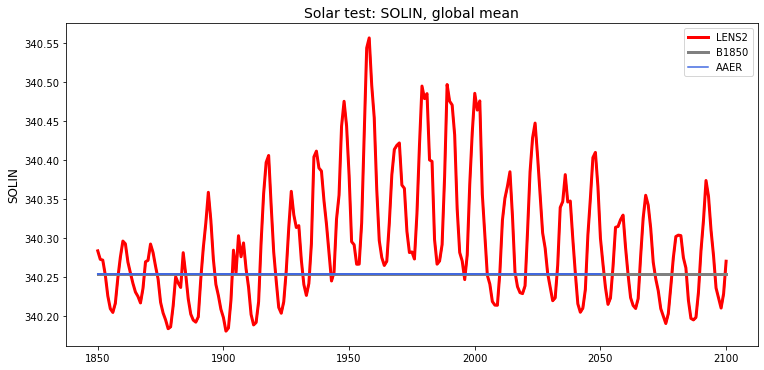

In [182]:
if ((flagtest[tests == 'solar']) == 0):
    print("sorry, you don't seem to have the SOLIN data necessary for the solar test")
else:
    print("Performing the solar test...")

fig = dothetest.testsolar(compareto, solarfiles, runshortname)      

### The Volcano test

Performing the volcano test...


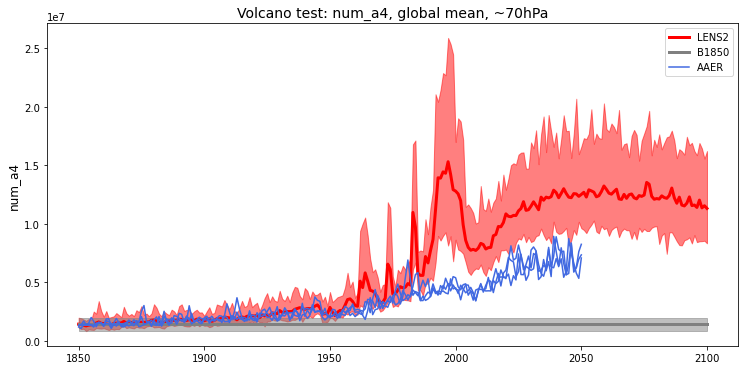

In [183]:
if ((flagtest[tests == 'volc']) == 0):
    print("sorry, you don't seem to have the num_a4 data necessary for the volcano test")
else:
    print("Performing the volcano test...")
    
fig = dothetest.testvolc(compareto, volcfiles, runshortname)

### The GHG test

In [ ]:
Still to do...

